In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/week7-dataset/Valid.csv
/kaggle/input/week7-dataset/Train.csv
/kaggle/input/week7-dataset/Test.csv


Your understanding of the NLP workflow and the use of embedding layers with LSTMs is mostly correct. Here's a refined breakdown of how it works step-by-step and how each component functions in the pipeline:

### 1. **Text Preprocessing**:
   - **Basic Cleaning**: Convert text to lowercase, remove punctuation, numbers, and other unwanted characters.
   - **Stopword Removal**: Remove common words that do not contribute significantly to the meaning of the text (e.g., "and", "the").
   - **Tokenization**: Split the text into individual words or tokens.
   - **Lemmatization**: Reduce words to their base or root form (e.g., "running" → "run").
   - **Rejoining**: Combine the tokens back into a processed text string if necessary.

### 2. **Tokenization & Conversion to Sequences**:
   - **Tokenizer Fitting**: Use `Tokenizer` from Keras to create a dictionary mapping words to integers.
     ```python
     from keras.preprocessing.text import Tokenizer
     
     tokenizer = Tokenizer(num_words=vocab_size)
     tokenizer.fit_on_texts(processed_texts)
     sequences = tokenizer.texts_to_sequences(processed_texts)
     ```
   - **Padding**: Ensure all sequences are of the same length for batch processing by padding them.
     ```python
     from keras.utils import pad_sequences
     
     max_length = 128  # Adjust according to your data
     padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
     ```

### 3. **Embedding Layer**:
   - The `Embedding` layer in Keras maps integer-encoded words to dense vectors of a fixed size (`output_dim`).
   - Parameters:
     - `input_dim`: Vocabulary size (total number of unique words in the tokenizer).
     - `output_dim`: Dimension of the dense embedding (e.g., 128).
     - `input_length`: Maximum length of input sequences.
     ```python
     from keras.models import Sequential
     from keras.layers import Embedding, LSTM, Dense
     
     model = Sequential()
     model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))
     ```

### 4. **LSTM Layer**:
   - The `LSTM` layer processes the sequence output from the `Embedding` layer. Each timestep in the input sequence is mapped to an output by the LSTM.
   - If the LSTM has 50 units, the output of the LSTM layer is a sequence of vectors (length defined by the sequence) with 50 features each.
     ```python
     model.add(LSTM(50, return_sequences=False))  # Change to True for sequence output
     ```

### 5. **Dense Layer**:
   - A fully connected `Dense` layer is often added after the LSTM layer for classification or regression tasks.
     ```python
     model.add(Dense(1, activation='sigmoid'))  # For binary classification
     ```

### 6. **Explanation of Data Flow**:
   - **Input**: The preprocessed and padded sequence (e.g., shape `(batch_size, max_length)`).
   - **Embedding Layer**: Maps each word in the sequence to a 128-dimensional vector, producing an output shape `(batch_size, max_length, 128)`.
   - **LSTM Layer**: Processes the embedded input and outputs a sequence with a shape depending on the configuration:
     - If `return_sequences=True`, output shape: `(batch_size, max_length, 50)`.
     - If `return_sequences=False`, output shape: `(batch_size, 50)`.
   - **Dense Layer**: Further processes the output for classification or regression.

### 7. **Training**:
   - Compile the model with appropriate loss functions and optimizers.
     ```python
     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
     model.fit(padded_sequences, labels, epochs=10, batch_size=32, validation_split=0.2)
     ```

### Key Points:
- **Output of Embedding Layer**: Each word in the input sequence is transformed into a dense vector of size `output_dim`.
- **LSTM Units**: The number of units in the LSTM determines the size of the hidden state vector for each time step.
- **Max Length**: Defines how many timesteps are passed to the LSTM at once.

This pipeline will enable your model to learn patterns in the text and predict based on it.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_df = pd.read_csv('/kaggle/input/week7-dataset/Train.csv')
test_df = pd.read_csv('/kaggle/input/week7-dataset/Test.csv')
valid_df = pd.read_csv('/kaggle/input/week7-dataset/Valid.csv')

In [4]:
train_df

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
...,...,...
39995,"""Western Union"" is something of a forgotten cl...",1
39996,This movie is an incredible piece of work. It ...,1
39997,My wife and I watched this movie because we pl...,0
39998,"When I first watched Flatliners, I was amazed....",1


In [5]:
test_df

,text,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0
...,...,...
4995,This is the kind of picture John Lassiter woul...,1
4996,A MUST SEE! I saw WHIPPED at a press screening...,1
4997,NBC should be ashamed. I wouldn't allow my chi...,0
4998,This movie is a clumsy mishmash of various gho...,0


In [6]:
valid_df

,text,label
0,It's been about 14 years since Sharon Stone aw...,0
1,someone needed to make a car payment... this i...,0
2,The Guidelines state that a comment must conta...,0
3,This movie is a muddled mish-mash of clichés f...,0
4,Before Stan Laurel became the smaller half of ...,0
...,...,...
4995,"Man, I loved this movie! This really takes me ...",1
4996,Recovery is an incredibly moving piece of work...,1
4997,"You can take the crook out of the joint, but i...",1
4998,FUTZ is the only show preserved from the exper...,1


In [14]:
import re
import string
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', "", text)
    text = re.sub('\\W', " ", text)
    text = re.sub("https?://\S+|www\.\S+", "", text)
    text = re.sub('<.*?>+', "", text)
    text = re.sub('[%s]' % re.escape(string.punctuation), "", text)
    text = re.sub('\n', "", text)
    text = re.sub('\w*\d\w*', "", text)
    
    return text
    

In [15]:
VOCAB = 10000
EMBEDDING_DIM = 128
MAX_LENGTH = 200

In [16]:
train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)
valid_df['text'] = valid_df['text'].apply(clean_text)

In [18]:
train_df['text']

0        i grew up  b    watching and loving the thunde...
1        when i put this movie in my dvd player  and sa...
2        why do people who do not know what a particula...
3        even though i have great interest in biblical ...
4        im a die hard dads army fan and nothing will e...
                               ...                        
39995     western union  is something of a forgotten cl...
39996    this movie is an incredible piece of work  it ...
39997    my wife and i watched this movie because we pl...
39998    when i first watched flatliners  i was amazed ...
39999    why would this film be so good  but only gross...
Name: text, Length: 40000, dtype: object

In [17]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
def tokenize_words(text):
    words = word_tokenize(text)
    return words

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [19]:
train_df['text'] = train_df['text'].apply(tokenize_words)
test_df['text'] = test_df['text'].apply(tokenize_words)
valid_df['text'] = valid_df['text'].apply(tokenize_words)

In [20]:
train_df['text']

0        [i, grew, up, b, watching, and, loving, the, t...
1        [when, i, put, this, movie, in, my, dvd, playe...
2        [why, do, people, who, do, not, know, what, a,...
3        [even, though, i, have, great, interest, in, b...
4        [im, a, die, hard, dads, army, fan, and, nothi...
                               ...                        
39995    [western, union, is, something, of, a, forgott...
39996    [this, movie, is, an, incredible, piece, of, w...
39997    [my, wife, and, i, watched, this, movie, becau...
39998    [when, i, first, watched, flatliners, i, was, ...
39999    [why, would, this, film, be, so, good, but, on...
Name: text, Length: 40000, dtype: object

In [22]:
from nltk.corpus import stopwords,wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
stop_words.add('br')
stop_words.add('b')
lemmatizer = WordNetLemmatizer()

def remove_stopwords_and_lemmatize(words):
    return [lemmatizer.lemmatize(word,pos='v') for word in words if word not in stop_words]

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
#to solve the useless problem of nltk
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [25]:
train_df['text'] = train_df['text'].apply(remove_stopwords_and_lemmatize)
test_df['text'] = test_df['text'].apply(remove_stopwords_and_lemmatize)
valid_df['text'] = valid_df['text'].apply(remove_stopwords_and_lemmatize)

In [26]:
train_df['text']

0        [grow, watch, love, thunderbirds, mat, school,...
1        [put, movie, dvd, player, sit, coke, chip, exp...
2        [people, know, particular, time, past, like, f...
3        [even, though, great, interest, biblical, movi...
4        [im, die, hard, dads, army, fan, nothing, ever...
                               ...                        
39995    [western, union, something, forget, classic, w...
39996    [movie, incredible, piece, work, explore, ever...
39997    [wife, watch, movie, plan, visit, sicily, stro...
39998    [first, watch, flatliners, amaze, necessary, f...
39999    [would, film, good, gross, estimate, award, no...
Name: text, Length: 40000, dtype: object

In [27]:
train_df['text'] = train_df['text'].apply(lambda x: ' '.join(x))
test_df['text'] = test_df['text'].apply(lambda x: ' '.join(x))
valid_df['text'] = valid_df['text'].apply(lambda x: ' '.join(x))

In [28]:
train_df['text']

0        grow watch love thunderbirds mat school watch ...
1        put movie dvd player sit coke chip expectation...
2        people know particular time past like feel nee...
3        even though great interest biblical movies bor...
4        im die hard dads army fan nothing ever change ...
                               ...                        
39995    western union something forget classic western...
39996    movie incredible piece work explore every nook...
39997    wife watch movie plan visit sicily stromboli s...
39998    first watch flatliners amaze necessary feature...
39999    would film good gross estimate award nominatio...
Name: text, Length: 40000, dtype: object

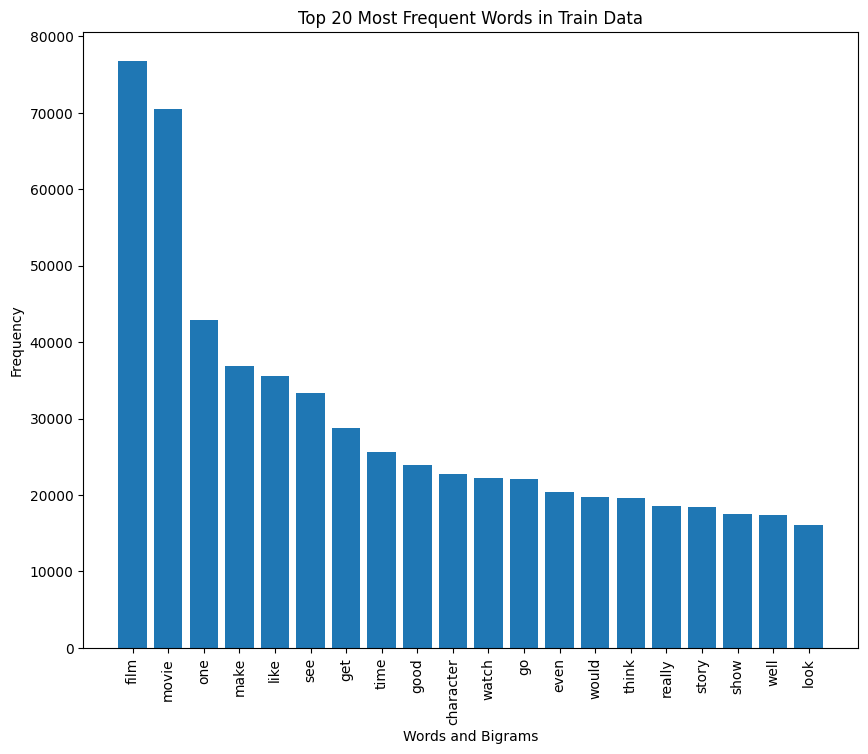

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range = (1,1))
cv_train = cv.fit_transform(train_df['text'])

df = pd.DataFrame(cv_train.sum(axis = 0),columns = cv.get_feature_names_out()).T.sort_values(by=0,ascending = False)

plt.figure(figsize = (10,8))
plt.bar(df.index[:20],df.iloc[:20,0])
plt.xticks(rotation=90)
plt.title('Top 20 Most Frequent Words in Train Data')
plt.xlabel('Words and Bigrams')
plt.ylabel('Frequency')
plt.show()

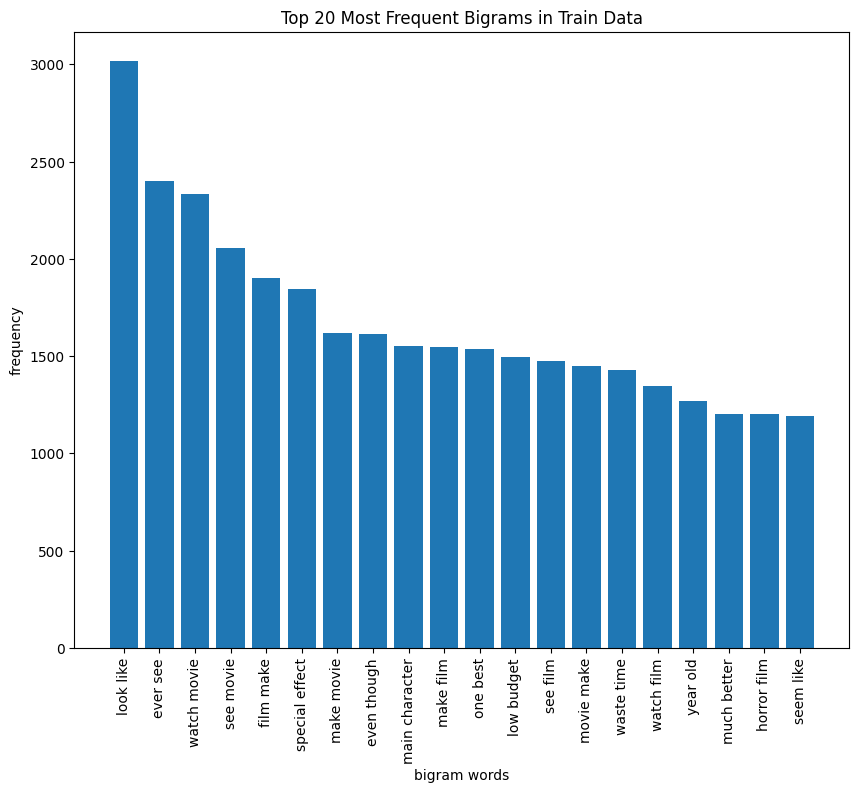

In [32]:
cv = CountVectorizer(ngram_range = (2,2))
cv_train = cv.fit_transform(train_df['text'])

df = pd.DataFrame(cv_train.sum(axis = 0), columns = cv.get_feature_names_out()).T.sort_values(by = 0,ascending = False)
plt.figure(figsize = (10,8))
plt.bar(df.index[:20],df.iloc[:20,0])
plt.xticks(rotation = 90)
plt.xlabel("bigram words")
plt.ylabel("frequency")
plt.title('Top 20 Most Frequent Bigrams in Train Data')
plt.show()

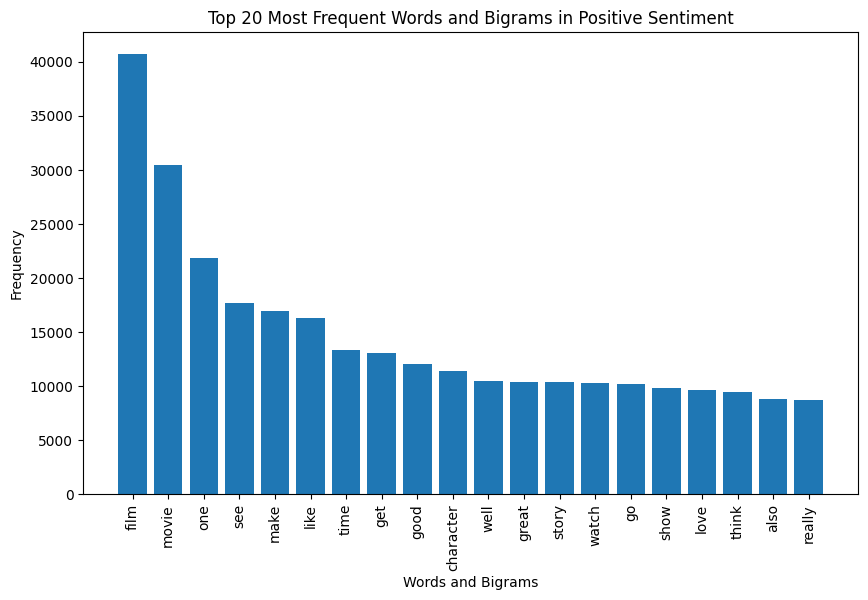

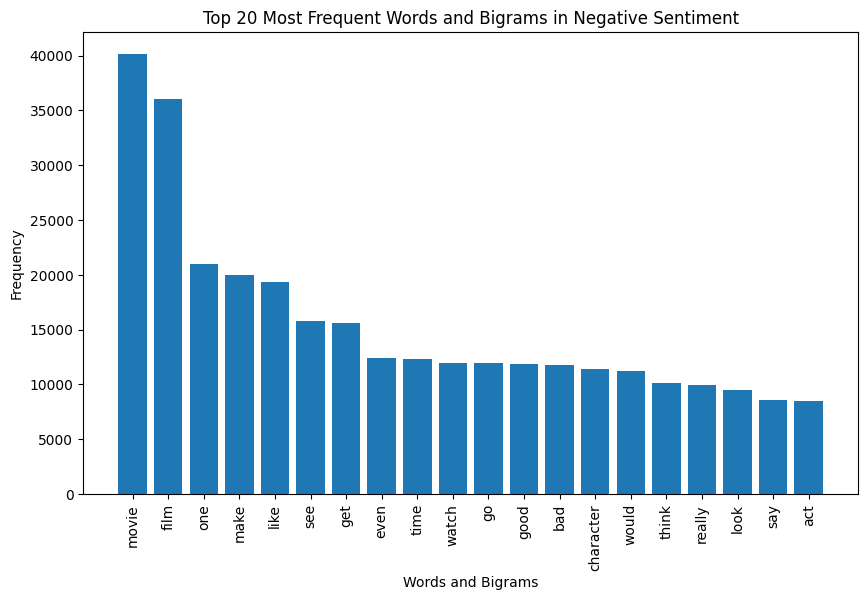

In [33]:
pos_df = train_df[train_df['label'] == 1]
neg_df = train_df[train_df['label'] == 0]

cv_pos = CountVectorizer(ngram_range=(1, 1))
cv_neg = CountVectorizer(ngram_range=(1, 1))
cv_train_pos = cv_pos.fit_transform(pos_df.iloc[:, 0])
cv_train_neg = cv_neg.fit_transform(neg_df.iloc[:, 0])

word_freq_pos = pd.DataFrame(cv_train_pos.sum(axis=0), columns=cv_pos.get_feature_names_out()).T.sort_values(by=0, ascending=False)
word_freq_neg = pd.DataFrame(cv_train_neg.sum(axis=0), columns=cv_neg.get_feature_names_out()).T.sort_values(by=0, ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(word_freq_pos.index[:20], word_freq_pos.iloc[:20, 0])
plt.xticks(rotation=90)
plt.title('Top 20 Most Frequent Words and Bigrams in Positive Sentiment')
plt.xlabel('Words and Bigrams')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(word_freq_neg.index[:20], word_freq_neg.iloc[:20, 0])
plt.xticks(rotation=90)
plt.title('Top 20 Most Frequent Words and Bigrams in Negative Sentiment')
plt.xlabel('Words and Bigrams')
plt.ylabel('Frequency')
plt.show()

In [34]:
#now creating the layers
VOCAB_SIZE = 10000
MAX_LENGTH = 200
OUTPUT_DIM = 128

In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'])
train_sequences = tokenizer.texts_to_sequences(train_df['text'])
train_sequences = pad_sequences(train_sequences,maxlen = MAX_LENGTH,padding = 'post',truncating = 'post')

In [36]:
train_sequences

array([[ 446,   11,   29, ...,    0,    0,    0],
       [ 129,    2,  174, ...,    0,    0,    0],
       [  26,   22,  710, ...,    0,    0,    0],
       ...,
       [ 224,   11,    2, ...,    0,    0,    0],
       [  31,   11, 9399, ...,    0,    0,    0],
       [  14,    1,    9, ...,    0,    0,    0]], dtype=int32)

In [37]:
test_sequences = tokenizer.texts_to_sequences(test_df['text'])
test_sequences = pad_sequences(test_sequences,maxlen=MAX_LENGTH,padding = 'post',truncating = 'post')

valid_sequences = tokenizer.texts_to_sequences(valid_df['text'])
valid_sequences = pad_sequences(valid_sequences,maxlen = MAX_LENGTH,padding = 'post',truncating = 'post')

In [38]:
train_labels= pd.get_dummies(train_df['label']).values
test_labels= pd.get_dummies(test_df['label']).values
val_labels= pd.get_dummies(valid_df['label']).values

In [39]:
train_labels

array([[ True, False],
       [ True, False],
       [ True, False],
       ...,
       [ True, False],
       [False,  True],
       [False,  True]])

In [40]:
train_labels_1 = train_df.iloc[:,-1]
test_labels_1 = test_df.iloc[:,-1]
valid_labels_1 = valid_df.iloc[:,-1]
train_labels_1

0        0
1        0
2        0
3        0
4        1
        ..
39995    1
39996    1
39997    0
39998    1
39999    1
Name: label, Length: 40000, dtype: int64

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,GRU,SimpleRNN,Bidirectional,Dropout,BatchNormalization,Input
from tensorflow.keras.optimizers import Adam
#3 layer lstm
lstm_model = Sequential([
    Input(shape = (MAX_LENGTH,),name = 'input'),
    Embedding(input_dim = VOCAB_SIZE,output_dim = OUTPUT_DIM,input_length = MAX_LENGTH),
    LSTM(128,activation = 'relu',return_sequences = True),
    BatchNormalization(),
    Dropout(0.5),
    LSTM(64,activation = 'relu',return_sequences = True),
    BatchNormalization(),
    Dropout(0.5),
    LSTM(64,activation = 'relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2,activation='sigmoid')#since labels like that
])

lstm_model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
lstm_model.summary()#since did dummies we get test as 2 labels so 2 neurons we are using in the output

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 200, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 200, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 200, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,495,170 (5.70 MB)

 Trainable params: 1,494,658 (5.70 MB)

 Non-trainable params: 512 (2.00 KB)

In [46]:
lstm_hist = lstm_model.fit(train_sequences, train_labels, epochs=3, validation_data=(valid_sequences, val_labels))

Epoch 1/3


I0000 00:00:1730635042.001568     984 service.cc:145] XLA service 0x7c44c0007ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730635042.001623     984 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   3/1250 ━━━━━━━━━━━━━━━━━━━━ 1:17 62ms/step - accuracy: 0.5573 - loss: 1.0493 

I0000 00:00:1730635047.670897     984 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 88s 61ms/step - accuracy: 0.5017 - loss: 0.9574 - val_accuracy: 0.5030 - val_loss: 0.7192
Epoch 2/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 75s 60ms/step - accuracy: 0.5050 - loss: 0.8597 - val_accuracy: 0.4922 - val_loss: 0.7511
Epoch 3/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 75s 60ms/step - accuracy: 0.4987 - loss: 0.7980 - val_accuracy: 0.4956 - val_loss: 0.7232


In [49]:
gru_model = Sequential([
    Input(shape = (MAX_LENGTH,)),#so this is the input 
    Embedding(input_dim=VOCAB_SIZE, output_dim=OUTPUT_DIM, input_length=MAX_LENGTH),
    GRU(128, activation = 'relu',return_sequences=True),
    BatchNormalization(),
    Dropout(0.5),
    GRU(64, activation = 'relu',return_sequences=True),
    BatchNormalization(),
    Dropout(0.5),
    GRU(64,activation = 'relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2, activation="sigmoid"),
])
gru_model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
gru_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 200, 128)       │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 200, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 200, 64)        │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 200, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,442,434 (5.50 MB)

 Trainable params: 1,441,922 (5.50 MB)

 Non-trainable params: 512 (2.00 KB)

In [51]:
gru_hist = gru_model.fit(train_sequences, train_labels, epochs=3, validation_data=(valid_sequences, val_labels))

Epoch 1/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 94s 68ms/step - accuracy: 0.5062 - loss: 0.9627 - val_accuracy: 0.5144 - val_loss: 0.7287
Epoch 2/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 66ms/step - accuracy: 0.5113 - loss: 0.8235 - val_accuracy: 0.5210 - val_loss: 0.7017
Epoch 3/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 66ms/step - accuracy: 0.5081 - loss: 0.7810 - val_accuracy: 0.5204 - val_loss: 0.6939


In [52]:
bid_model = Sequential([
    Input(shape = (MAX_LENGTH,)),
    Embedding(input_dim=VOCAB_SIZE, output_dim=OUTPUT_DIM, input_length=MAX_LENGTH),
    Bidirectional(LSTM(128,activation = 'relu',return_sequences=True)),
    BatchNormalization(),
    Dropout(0.5),
    Bidirectional(LSTM(64,activation = 'relu',return_sequences=True)),
    BatchNormalization(),
    Dropout(0.5),
    Bidirectional(LSTM(64,activation = 'relu' ,return_sequences=True)),
    BatchNormalization(),
    Dropout(0.5),
    Bidirectional(LSTM(32,activation = 'relu')),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2, activation="sigmoid"),
])
bid_model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
bid_model.summary()#see how the shape is double for each layer

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 200, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 200, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 200, 128)       │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 200, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 200, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 200, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,849,986 (7.06 MB)

 Trainable params: 1,848,834 (7.05 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [54]:
bid_hist = bid_model.fit(train_sequences, train_labels, epochs=3, validation_data=(valid_sequences, val_labels))
#did 3 for all as takes time for learning hegu mathe madbodu
#also without the activation giving better and also input added imp so shape seen and
#idralli why no loss god knows???

Epoch 1/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 216s 159ms/step - accuracy: 0.5021 - loss: nan - val_accuracy: 0.5028 - val_loss: nan
Epoch 2/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 195s 156ms/step - accuracy: 0.4931 - loss: nan - val_accuracy: 0.5028 - val_loss: nan
Epoch 3/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 196s 157ms/step - accuracy: 0.5007 - loss: nan - val_accuracy: 0.5028 - val_loss: nan


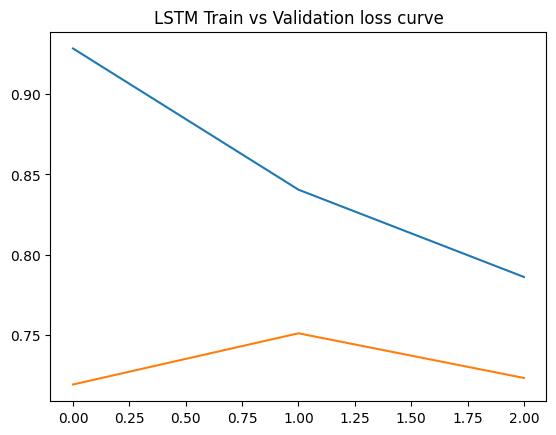

In [55]:
plt.title("LSTM Train vs Validation loss curve")
plt.plot(range(3), lstm_hist.history["loss"])
plt.plot(range(3), lstm_hist.history["val_loss"])

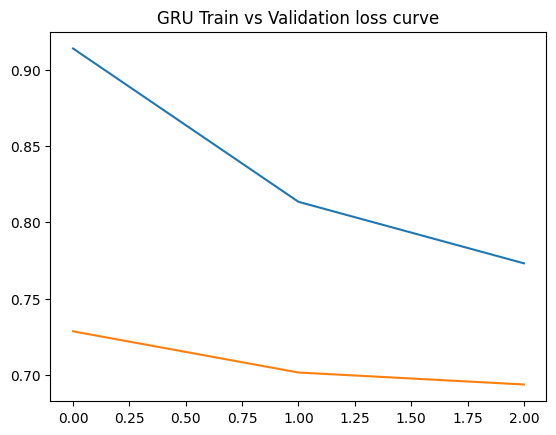

In [56]:
plt.title("GRU Train vs Validation loss curve")
plt.plot(range(3), gru_hist.history["loss"])
plt.plot(range(3), gru_hist.history["val_loss"])

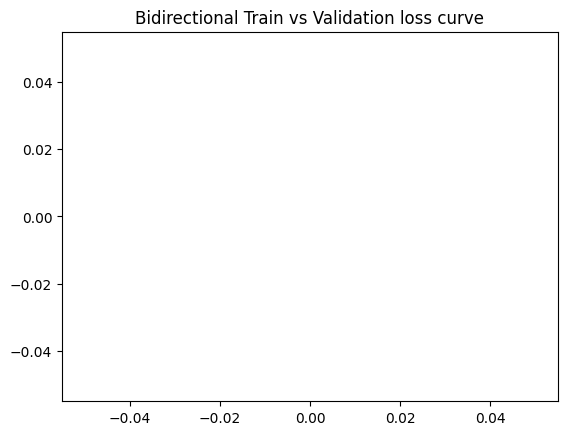

In [57]:
plt.title("Bidirectional Train vs Validation loss curve")
plt.plot(range(3), bid_hist.history["loss"])
plt.plot(range(3), bid_hist.history["val_loss"])

In [58]:
from sklearn.metrics import accuracy_score
predictions = lstm_model.predict(test_sequences)
predicted_labels = [int(round(np.argmax(x))) for x in predictions]
lstm_acc = accuracy_score(test_labels_1,predicted_labels)
lstm_acc

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


0.502

In [59]:
predictions = gru_model.predict(test_sequences)
predicted_labels = [int(round(np.argmax(x))) for x in predictions]
gru_acc = accuracy_score(test_labels_1,predicted_labels)
gru_acc

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


0.5144

In [61]:
predictions = bid_model.predict(test_sequences)
predicted_labels = [int(round(np.argmax(x))) for x in predictions]
bid_acc = accuracy_score(test_labels_1,predicted_labels)
bid_acc

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step


0.499

In [62]:
results = []

results.append([
    '3 Layer LSTM Model',
    np.array(lstm_hist.history['accuracy']).mean(),
    np.array(lstm_hist.history['val_accuracy']).mean(),
    np.array(lstm_hist.history['loss']).mean(),
    np.array(lstm_hist.history['val_loss']).mean(),
    lstm_acc
])
results.append([
    '3 Layer GRU Model',
    np.array(gru_hist.history['accuracy']).mean(),
    np.array(gru_hist.history['val_accuracy']).mean(),
    np.array(gru_hist.history['loss']).mean(),
    np.array(gru_hist.history['val_loss']).mean(),
    gru_acc
])
results.append([
    '4 Layer Bidirectional RNN Model',
    np.array(bid_hist.history['accuracy']).mean(),
    np.array(bid_hist.history['val_accuracy']).mean(),
    np.array(bid_hist.history['loss']).mean(),
    np.array(bid_hist.history['val_loss']).mean(),
    bid_acc
])

columns = ['Model', 'Mean Training Accuracy', 'Mean Validation Accuracy', 'Mean Training Loss', 'Mean Validation Loss', 'Test Accuracy']
results_df = pd.DataFrame(results, columns=columns)

results_df

,Model,Mean Training Accuracy,Mean Validation Accuracy,Mean Training Loss,Mean Validation Loss,Test Accuracy
0,3 Layer LSTM Model,0.502583,0.496933,0.851677,0.731157,0.5020
1,3 Layer GRU Model,0.506325,0.518600,0.833445,0.708079,0.5144
2,4 Layer Bidirectional RNN Model,0.499408,0.502800,NaN,NaN,0.4990
